In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
#Gerando as features que serão usadas no modelo
import sys, os
sys.path.append(os.path.abspath('..'))
from pre_processamento.processamento_dados import processamento
# --- Importações necessárias ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = processamento()
#Gerando os dados de hora e mês para situar o modelo
df['hora'] = df.index.hour
df['mes'] = df.index.month
#Gerando os lags que serão usados como features
df['lag_1'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(1)
df['lag_2'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(2)
df['lag_3'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(3)
df = df.dropna()
#Gerando os datasets de treino validação e teste
# Definindo o período de treino (2010)
train_end = '2010-12-31 23:00:00'
X_train = df[['hora', 'mes', 'lag_1', 'lag_2', 'lag_3']].loc[:train_end]
y_train = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[:train_end]
#Definindo o período de validação (2011)
val_end = '2011-12-31 23:00:00'
val_start = '2011-01-01 00:00:00'
X_val = df[['hora', 'mes', 'lag_1', 'lag_2', 'lag_3']].loc[val_start:val_end]
y_val = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[val_start:val_end]
#Definindo o período de teste (2012)
test_start = '2012-01-01 00:00:00'
X_test = df[['hora', 'mes', 'lag_1', 'lag_2', 'lag_3']].loc[test_start:]
y_test = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[test_start:]


In [3]:
X_train.head()

,hora,mes,lag_1,lag_2,lag_3
DATETIME,,,,,
2010-01-01 03:00:00,3,1,20.8,21.1,21.6
2010-01-01 04:00:00,4,1,20.5,20.8,21.1
2010-01-01 05:00:00,5,1,20.0,20.5,20.8
2010-01-01 06:00:00,6,1,19.5,20.0,20.5
2010-01-01 07:00:00,7,1,20.0,19.5,20.0


In [4]:
y_train.head()

DATETIME
2010-01-01 03:00:00    20.5
2010-01-01 04:00:00    20.0
2010-01-01 05:00:00    19.5
2010-01-01 06:00:00    20.0
2010-01-01 07:00:00    20.8
Name: TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C), dtype: float64

In [5]:
X_val.head()

,hora,mes,lag_1,lag_2,lag_3
DATETIME,,,,,
2011-01-01 00:00:00,0,1,24.1,25.2,26.8
2011-01-01 01:00:00,1,1,22.8,24.1,25.2
2011-01-01 02:00:00,2,1,22.3,22.8,24.1
2011-01-01 03:00:00,3,1,21.7,22.3,22.8
2011-01-01 04:00:00,4,1,21.4,21.7,22.3



Dados prontos! Agora o Teste contém apenas o período equivalente ao Treino.

=== 4.1 VISUALIZAÇÃO DA SÉRIE TEMPORAL ===


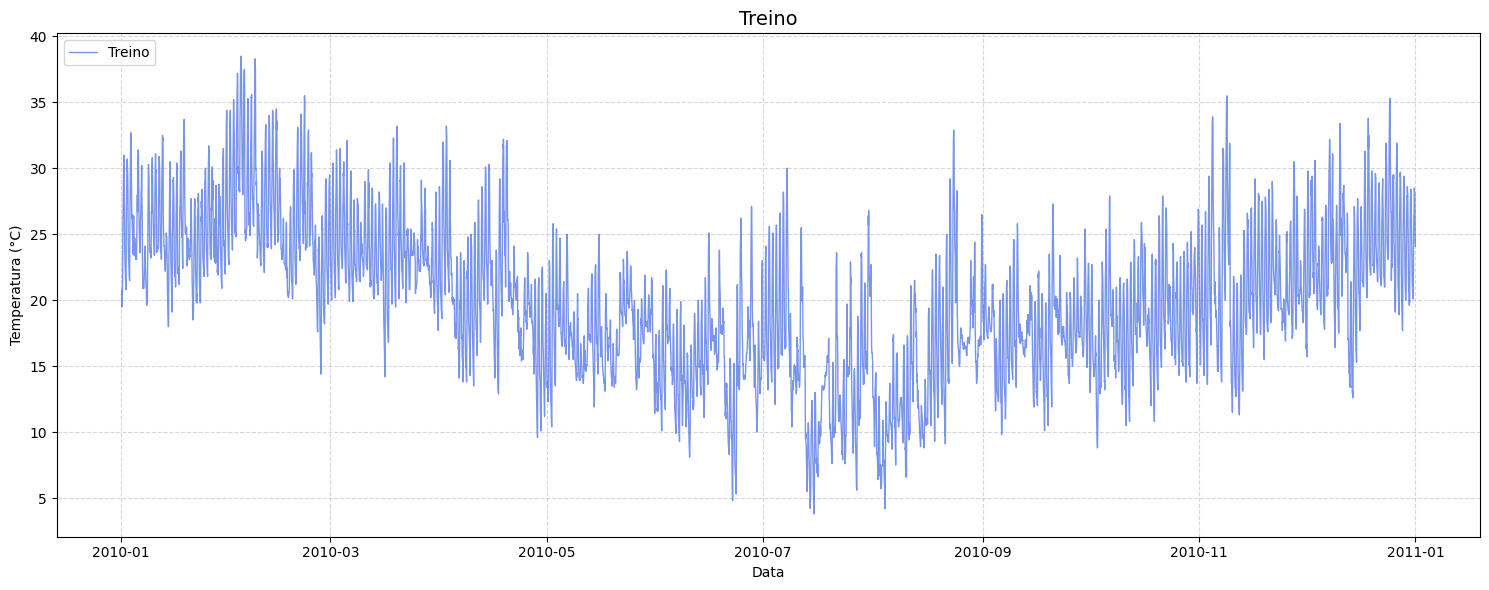

In [6]:
#Normalização
scaler = StandardScaler()

# Ajusta a régua (fit) apenas no TREINO
X_train_scaled = scaler.fit_transform(X_train)

# Aplica a régua na Validação e no Teste
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Converte de volta para DataFrame para manter colunas e índices
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index)

print("\nDados prontos! Agora o Teste contém apenas o período equivalente ao Treino.")

# ==============================================================================
# 4.1 VISUALIZAÇÃO DA DIVISÃO TEMPORAL
# ==============================================================================
print("\n=== 4.1 VISUALIZAÇÃO DA SÉRIE TEMPORAL ===")

plt.figure(figsize=(15, 6))

# 1. Plot do Treino (Azul)
plt.plot(y_train.index, y_train, label='Treino', color='royalblue', alpha=0.7, linewidth=1)

# Detalhes do Gráfico
plt.title('Treino', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)

# Ajuste para não cortar datas
plt.tight_layout()
plt.show()

In [13]:
# --- Modelagem, avaliação e tunagem (TimeSeriesSplit + RandomSearch) ---
print("\n=== 5. MODELAGEM E TUNAGEM (TimeSeriesSplit + RandomSearch) ===")

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint, uniform

# Concatenar dados de treino e validação para usar TimeSeriesSplit
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

print(f"Conjunto combinado (Treino + Validação): {len(X_combined)} amostras")

# Valores de n_splits a testar
n_splits_values = [3, 5, 10]

# Definição de pipelines e distribuições de hiperparâmetros para RandomSearch
models_config = {
    'Random Forest': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
        ]),
        'param_distributions': {
            'model__n_estimators': randint(50, 1000),
            'model__max_depth': [None, 5, 10, 15, 20, 30, 40, 50],
            'model__min_samples_split': randint(2, 100),
            'model__min_samples_leaf': randint(1, 100),
            'model__max_features': ['sqrt', 'log2', None]
        },
        'n_iter': 100  # número de combinações a testar
    },
    'Gradient Boosting': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('model', GradientBoostingRegressor(random_state=42))
        ]),
        'param_distributions': {
            'model__n_estimators': randint(50, 1000),
            'model__learning_rate': uniform(0.01, 0.3),
            'model__max_depth': randint(2, 100),
            'model__min_samples_split': randint(2, 100),
            'model__min_samples_leaf': randint(1, 100),
            'model__subsample': uniform(0.5, 0.5)
        },
        'n_iter':100  # número de combinações a testar
    }
}

# Métrica de scoring (RMSE negativo para sklearn)
scoring = make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)))

# Armazenar resultados da tunagem
tuning_results = []
best_per_model = {}

for model_name, config in models_config.items():
    print(f"\n{'='*80}")
    print(f"Tunando {model_name} com RandomSearch")
    print(f"{'='*80}")
    
    pipeline_template = config['pipeline']
    param_distributions = config['param_distributions']
    n_iter = config['n_iter']
    
    best_overall_score = np.inf
    best_overall_config = None
    
    for n_splits in n_splits_values:
        print(f"\n--- n_splits = {n_splits} ---")
        
        # Configurar TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        # RandomizedSearchCV: testa n_iter combinações aleatórias
        random_search = RandomizedSearchCV(
            estimator=pipeline_template,
            param_distributions=param_distributions,
            n_iter=n_iter,
            cv=tscv,
            scoring=scoring,
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        # Executar tunagem
        t0 = time.time()
        random_search.fit(X_combined, y_combined)
        tuning_time = time.time() - t0
        
        # Melhor resultado para este n_splits
        best_score = -random_search.best_score_  # converter de volta para RMSE positivo
        best_params = random_search.best_params_
        best_model = random_search.best_estimator_
        
        print(f"\nMelhor RMSE para n_splits={n_splits}: {best_score:.4f}")
        print(f"Melhores hiperparâmetros: {best_params}")
        print(f"Tempo de tunagem: {tuning_time:.2f}s")
        
        # Calcular métricas adicionais com validação cruzada
        cv_scores_rmse = []
        cv_scores_r2 = []
        cv_scores_mae = []
        cv_scores_mape = []
        
        for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X_combined)):
            X_train_fold = X_combined.iloc[train_idx]
            y_train_fold = y_combined.iloc[train_idx]
            X_test_fold = X_combined.iloc[test_idx]
            y_test_fold = y_combined.iloc[test_idx]
            
            fold_model = random_search.best_estimator_
            fold_model.fit(X_train_fold, y_train_fold)
            y_pred_fold = fold_model.predict(X_test_fold)
            
            cv_scores_rmse.append(np.sqrt(mean_squared_error(y_test_fold, y_pred_fold)))
            cv_scores_r2.append(r2_score(y_test_fold, y_pred_fold))
            cv_scores_mae.append(mean_absolute_error(y_test_fold, y_pred_fold))
            cv_scores_mape.append(mean_absolute_percentage_error(y_test_fold, y_pred_fold) * 100)
        
        # Agregar métricas
        metrics_agg = {
            'rmse_mean': float(np.mean(cv_scores_rmse)),
            'rmse_std': float(np.std(cv_scores_rmse)),
            'r2_mean': float(np.mean(cv_scores_r2)),
            'r2_std': float(np.std(cv_scores_r2)),
            'mae_mean': float(np.mean(cv_scores_mae)),
            'mape_mean': float(np.mean(cv_scores_mape))
        }
        
        # Armazenar resultado
        result = {
            'model': model_name,
            'n_splits': int(n_splits),
            'n_iter_tested': int(n_iter),
            'best_params': best_params,
            'tuning_time_s': float(tuning_time),
            **metrics_agg
        }
        tuning_results.append(result)
        
        # Atualizar melhor configuração global
        if metrics_agg['rmse_mean'] < best_overall_score:
            best_overall_score = metrics_agg['rmse_mean']
            best_overall_config = {
                'n_splits': int(n_splits),
                'best_params': best_params,
                'best_model': best_model,
                'metrics': metrics_agg
            }
    
    # Salvar melhor modelo
    if best_overall_config is not None:
        best_per_model[model_name] = best_overall_config
        print(f"\n{'*'*80}")
        print(f"Melhor configuração para {model_name}:")
        print(f"  n_splits: {best_overall_config['n_splits']}")
        print(f"  RMSE: {best_overall_config['metrics']['rmse_mean']:.4f} ± {best_overall_config['metrics']['rmse_std']:.4f}")
        print(f"  R2:   {best_overall_config['metrics']['r2_mean']:.4f} ± {best_overall_config['metrics']['r2_std']:.4f}")
        print(f"  MAE:  {best_overall_config['metrics']['mae_mean']:.4f}")
        print(f"  MAPE: {best_overall_config['metrics']['mape_mean']:.2f}%")
        print(f"  Hiperparâmetros: {best_overall_config['best_params']}")
        print(f"{'*'*80}\n")

# Mostrar resumo completo da tunagem
df_tuning = pd.DataFrame(tuning_results)
if not df_tuning.empty:
    print("\n=== Resumo Completo da Tunagem (RandomSearch + TimeSeriesSplit) ===")
    display(df_tuning.sort_values(['model', 'rmse_mean']).reset_index(drop=True))

# Resumo dos melhores modelos
print('\n' + '='*80)
print('=== MELHORES CONFIGURAÇÕES FINAIS POR MODELO ===')
print('='*80)
for m, info in best_per_model.items():
    print(f"\n{m}:")
    print(f"  n_splits (melhor): {info['n_splits']}")
    print(f"  RMSE (validação):  {info['metrics']['rmse_mean']:.4f} ± {info['metrics']['rmse_std']:.4f}")
    print(f"  R2 (validação):    {info['metrics']['r2_mean']:.4f} ± {info['metrics']['r2_std']:.4f}")
    print(f"  MAE (validação):   {info['metrics']['mae_mean']:.4f}")
    print(f"  MAPE (validação):  {info['metrics']['mape_mean']:.2f}%")
    print(f"\n  Melhores hiperparâmetros encontrados:")
    for param, value in info['best_params'].items():
        print(f"    - {param}: {value}")

# Nota: RandomizedSearchCV testa n_iter combinações aleatórias de hiperparâmetros
# dentro das distribuições especificadas, mais eficiente que GridSearch para espaços grandes.
# Validação realizada com TimeSeriesSplit para respeitar ordem temporal.



=== 5. MODELAGEM E TUNAGEM (TimeSeriesSplit + RandomSearch) ===
Conjunto combinado (Treino + Validação): 17517 amostras

Tunando Random Forest com RandomSearch

--- n_splits = 3 ---
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Melhor RMSE para n_splits=3: 0.7618
Melhores hiperparâmetros: {'model__max_depth': 50, 'model__max_features': None, 'model__min_samples_leaf': 9, 'model__min_samples_split': 20, 'model__n_estimators': 865}
Tempo de tunagem: 112.49s

--- n_splits = 5 ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Melhor RMSE para n_splits=5: 0.8888
Melhores hiperparâmetros: {'model__max_depth': 50, 'model__max_features': None, 'model__min_samples_leaf': 9, 'model__min_samples_split': 20, 'model__n_estimators': 865}
Tempo de tunagem: 173.75s

--- n_splits = 10 ---
Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Melhor RMSE para n_splits=10: 0.8904
Melhores hiperparâmetros: {'model__max_depth': 50, 'model__max_features': Non

,model,n_splits,n_iter_tested,best_params,tuning_time_s,rmse_mean,rmse_std,r2_mean,r2_std,mae_mean,mape_mean
0,Gradient Boosting,3,100,"{'model__learning_rate': 0.05286004537658223, ...",393.844697,0.733408,0.044613,0.983015,0.002942,0.497881,2.965306
1,Gradient Boosting,10,100,"{'model__learning_rate': 0.2239734361668985, '...",1233.988252,0.811350,0.161241,0.963817,0.016851,0.548493,3.340560
2,Gradient Boosting,5,100,"{'model__learning_rate': 0.2239734361668985, '...",629.293079,0.837883,0.197055,0.963804,0.019828,0.571012,3.689703
3,Random Forest,3,100,"{'model__max_depth': 50, 'model__max_features'...",112.492072,0.761783,0.038395,0.981719,0.002741,0.509598,3.027226
4,Random Forest,5,100,"{'model__max_depth': 50, 'model__max_features'...",173.748801,0.888838,0.282924,0.957348,0.031534,0.586964,3.977555
5,Random Forest,10,100,"{'model__max_depth': 50, 'model__max_features'...",341.848258,0.890369,0.290673,0.953717,0.034727,0.583923,3.684471



=== MELHORES CONFIGURAÇÕES FINAIS POR MODELO ===

Random Forest:
  n_splits (melhor): 3
  RMSE (validação):  0.7618 ± 0.0384
  R2 (validação):    0.9817 ± 0.0027
  MAE (validação):   0.5096
  MAPE (validação):  3.03%

  Melhores hiperparâmetros encontrados:
    - model__max_depth: 50
    - model__max_features: None
    - model__min_samples_leaf: 9
    - model__min_samples_split: 20
    - model__n_estimators: 865

Gradient Boosting:
  n_splits (melhor): 3
  RMSE (validação):  0.7334 ± 0.0446
  R2 (validação):    0.9830 ± 0.0029
  MAE (validação):   0.4979
  MAPE (validação):  2.97%

  Melhores hiperparâmetros encontrados:
    - model__learning_rate: 0.05286004537658223
    - model__max_depth: 4
    - model__min_samples_leaf: 22
    - model__min_samples_split: 54
    - model__n_estimators: 819
    - model__subsample: 0.8609993861334124


In [12]:
# 3. Identificação do Melhor Modelo (sem Intervalos de Confiança)
# agora df_results está indexado por 'Modelo'
best_name = df_results['R2 Score'].idxmax()
best_model_pipeline = trained_models[best_name]
print(f"\n>>> CAMPEÃO: {best_name}")
print(f">>> R2 Score: {df_results.loc[best_name, 'R2 Score']:.4f}")

# 4. Previsão 1-step no Teste (apenas a primeira amostra de X_test)
if len(X_test) == 0:
    raise ValueError('X_test está vazio — nada a prever')

X_test_first = X_test.iloc[[0]]
y_test_first = y_test.iloc[[0]]

# previsão 1-step
y_final = best_model_pipeline.predict(X_test_first)

y_true_arr = y_test_first.values.flatten()
y_pred_arr = np.atleast_1d(y_final).flatten()

rmse_1step = np.sqrt(mean_squared_error(y_true_arr, y_pred_arr))
mae_1step = mean_absolute_error(y_true_arr, y_pred_arr)
# MAPE pode lançar erro/dividir por zero para valor real 0
try:
    mape_1step = mean_absolute_percentage_error(y_true_arr, y_pred_arr) * 100
except Exception:
    mape_1step = float('nan')
# R2 precisa de >=2 amostras; tratar caso de 1 amostra
try:
    r2_1step = r2_score(y_true_arr, y_pred_arr)
except Exception:
    r2_1step = float('nan')

print("\n=== MÉTRICAS 1-step (Teste) ===")
print(f"RMSE (1-step): {rmse_1step:.4f}")
print(f"MAE (1-step): {mae_1step:.4f}")
if np.isfinite(mape_1step):
    print(f"MAPE (1-step): {mape_1step:.2f}%")
else:
    print("MAPE (1-step): N/A")
if np.isfinite(r2_1step):
    print(f"R2 (1-step): {r2_1step:.4f}")
else:
    print("R2 (1-step): N/A (menos de 2 amostras)")

# Exibir valores individuais já existentes
print(f"\nÍndice previsto: {y_test_first.index[0]}")
print(f"Valor real: {y_test_first.values[0]:.3f}")
print(f"Valor previsto (1-step): {y_pred_arr[0]:.3f}")



>>> CAMPEÃO: Gradient Boosting
>>> R2 Score: 0.9841

=== MÉTRICAS 1-step (Teste) ===
RMSE (1-step): 0.8074
MAE (1-step): 0.8074
MAPE (1-step): 4.46%
R2 (1-step): N/A (menos de 2 amostras)

Índice previsto: 2012-01-01 00:00:00
Valor real: 18.100
Valor previsto (1-step): 18.907


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
